In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the Longley dataset
data = sm.datasets.longley.load_pandas().data

# Use YEAR as the index
data.index = data['YEAR']

y = data['TOTEMP']
X = data.drop(columns=['TOTEMP'])
X = sm.add_constant(X)

# Print shapes
print("Shape of y:", y.shape)
print("Shape of X:", X.shape)

Shape of y: (16,)
Shape of X: (16, 7)


In [2]:
# Split into training and test sets
n_obs = len(data)
split_idx = int(n_obs * 0.7)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

# Print shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (11, 7)
Shape of y_train: (11,)
Shape of X_test: (5, 7)
Shape of y_test: (5,)


In [3]:
# Fit an ordinary least squares regression on the training data
model = sm.OLS(y_train, X_train).fit()

# Extract the estimated coefficients (Beta_hat) as a NumPy array
params = model.params.values

# Extract the covariance matrix of the coefficient estimates
cov_matrix = model.cov_params().values

# Estimate the residual standard deviation sigma = sqrt(SSR / (n − p))
sigma = np.sqrt(model.scale)

In [4]:
# Monte Carlo predictive simulation
n_sims = 10_000  # number of Monte Carlo draws

# Sample regression coefficients from their approximate multivariate Normal posterior
beta_mc = np.random.multivariate_normal(
    mean=params,
    cov=cov_matrix,
    size=n_sims,
)

In [5]:
# Compute the predicted mean responses mu_mc for each draw at the test points
# This results in an (n_sims by n_test) array
mu_mc = beta_mc.dot(X_test.values.T)

# Add iid Normal noise epsilon ~ N(0, sigma^2) to each draw to get full predictive draws y_mc
eps_mc = np.random.normal(
    loc=0.0,
    scale=sigma,
    size=(n_sims, X_test.shape[0]),
)
y_mc = mu_mc + eps_mc

In [6]:
# Compute Monte Carlo credible intervals for the mean (CI) and prediction intervals (PI)
ci_lower_mc = np.percentile(mu_mc, 2.5, axis=0)
ci_upper_mc = np.percentile(mu_mc, 97.5, axis=0)
pi_lower_mc = np.percentile(y_mc, 2.5, axis=0)
pi_upper_mc = np.percentile(y_mc, 97.5, axis=0)

# Record the median of the predictive distribution
median_mc = np.percentile(y_mc, 50.0, axis=0)

In [7]:
# Fit once on training data to get residuals
fitted_vals = model.fittedvalues.values
residuals = y_train.values - fitted_vals
sigma_hat = np.std(residuals, ddof=X_train.shape[1])

# Bootstrap predictive simulation
n_boot = n_sims  # use the same number of bootstrap replicates

# Pre-allocate arrays to hold bootstrap mean and predictive draws
mu_boot = np.empty((n_boot, X_test.shape[0]))
y_boot = np.empty((n_boot, X_test.shape[0]))

# Initialize a NumPy random generator for reproducibility
rng = np.random.default_rng(42)

for i in range(n_boot):
    # Resample residuals
    resampled = rng.choice(residuals, size=len(residuals), replace=True)

    # Create pseudo-response and refit
    y_star = fitted_vals + resampled
    beta_star = np.linalg.lstsq(
        X_train.values,
        y_star,
        rcond=None
    )[0]

    # Predict and add new noise
    mu_b = X_test.values.dot(beta_star)
    eps_b = rng.normal(
        loc=0.0,
        scale=sigma_hat,
        size=X_test.shape[0]
    )
    mu_boot[i] = mu_b
    y_boot[i] = mu_b + eps_b

In [8]:
# Compute bootstrap credible and prediction intervals
ci_lower_boot = np.percentile(mu_boot, 2.5, axis=0)
ci_upper_boot = np.percentile(mu_boot, 97.5, axis=0)
pi_lower_boot = np.percentile(y_boot, 2.5, axis=0)
pi_upper_boot = np.percentile(y_boot, 97.5, axis=0)

# Median
median_boot = np.percentile(y_boot, 50.0, axis=0)

In [9]:
# Combine actual values, Monte Carlo summaries, and bootstrap summaries
results = pd.DataFrame(
    {
        'Actual Values': y_test.values,
        'MC Median': median_mc,
        'MC CI Lower': ci_lower_mc,
        'MC CI Upper': ci_upper_mc,
        'MC PI Lower': pi_lower_mc,
        'MC PI Upper': pi_upper_mc,
        'BT Median': median_boot,
        'BT CI Lower': ci_lower_boot,
        'BT CI Upper': ci_upper_boot,
        'BT PI Lower': pi_lower_boot,
        'BT PI Upper': pi_upper_boot,
    },
    index=y_test.index,
)

display(results.T.round(1).rename(columns=lambda yr: int(yr)))

YEAR,1958,1959,1960,1961,1962
Actual Values,66513.0,68655.0,69564.0,69331.0,70551.0
MC Median,67040.6,69603.3,70730.6,70882.4,73296.6
MC CI Lower,65360.0,67704.6,68106.4,65987.5,66971.1
MC CI Upper,68689.4,71457.5,73277.5,75611.3,79543.4
MC PI Lower,65245.3,67564.5,68036.2,65918.3,66896.9
MC PI Upper,68858.0,71603.6,73376.6,75661.0,79541.3
BT Median,66996.5,69576.5,70674.8,70772.7,73154.8
BT CI Lower,66027.4,68475.7,69152.8,67936.4,69486.3
BT CI Upper,68064.4,70745.4,72286.7,73718.0,76966.8
BT PI Lower,65785.7,68267.7,69002.6,67831.2,69411.5


In [10]:
# Compute out-of-sample performance metrics and coverage probabilities
metrics = pd.DataFrame(
    {
        'RMSE_MC': [np.sqrt(mean_squared_error(y_test, median_mc))],
        'RMSE_BT': [np.sqrt(mean_squared_error(y_test, median_boot))],
        'MAE_MC': [mean_absolute_error(y_test, median_mc)],
        'MAE_BT': [mean_absolute_error(y_test, median_boot)],
        'Cov_MC_PI': [
            np.mean((y_test.values >= pi_lower_mc) & (y_test.values <= pi_upper_mc))
        ],
        'Cov_BT_PI': [
            np.mean((y_test.values >= pi_lower_boot) & (y_test.values <= pi_upper_boot))
        ],
        'Cov_MC_CI': [
            np.mean((y_test.values >= ci_lower_mc) & (y_test.values <= ci_upper_mc))
        ],
        'Cov_BT_CI': [
            np.mean((y_test.values >= ci_lower_boot) & (y_test.values <= ci_upper_boot))
        ],
    },
    index=['Value']
)

display(metrics.T.round(2))

,Value
RMSE_MC,1580.11
RMSE_BT,1494.99
MAE_MC,1387.90
MAE_BT,1312.25
Cov_MC_PI,1.00
Cov_BT_PI,1.00
Cov_MC_CI,1.00
Cov_BT_CI,1.00


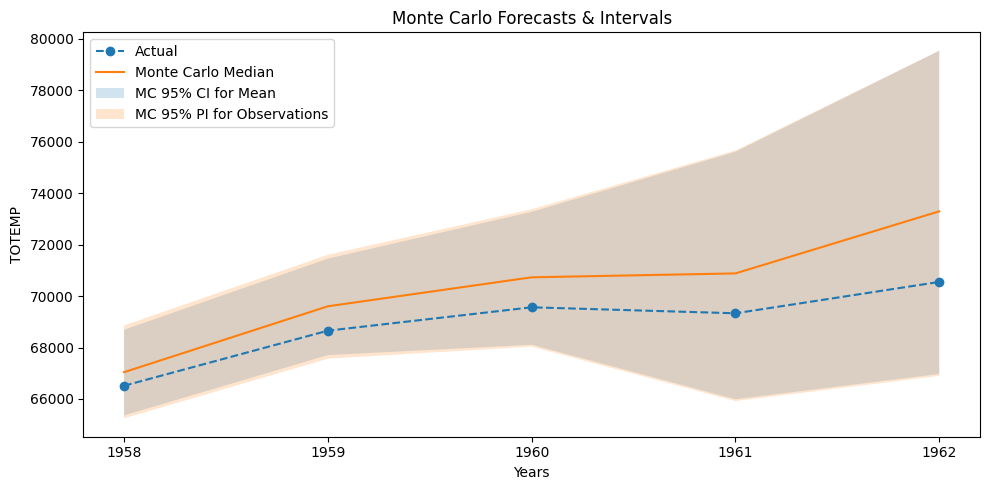

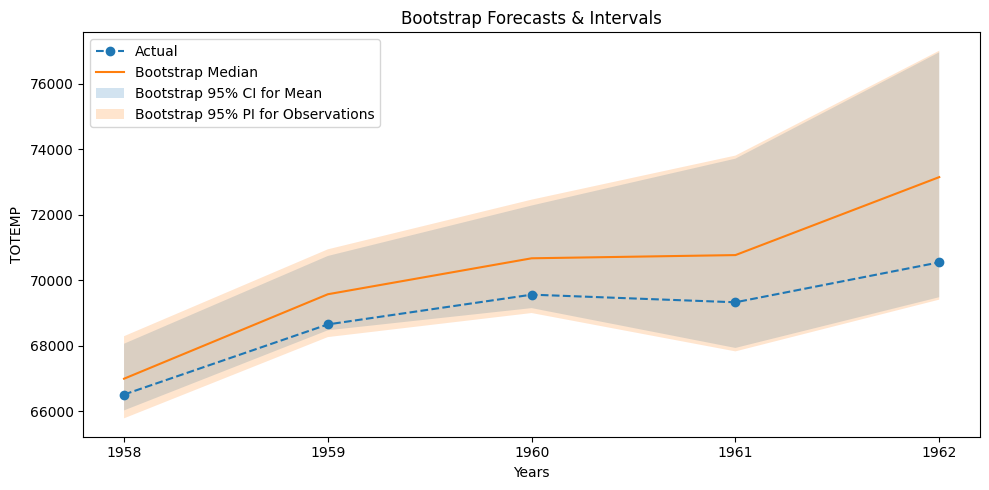

In [11]:
# Visualize forecasts and intervals
x_axis = results.index  # use test set indices on the x-axis

# Plot Monte Carlo-based forecasts and their intervals
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    x_axis,
    results['Actual Values'],
    label='Actual',
    linestyle='--',
    marker='o',
)
ax.plot(
    x_axis,
    results['MC Median'],
    label='Monte Carlo Median',
)
ax.fill_between(
    x_axis,
    results['MC CI Lower'],
    results['MC CI Upper'],
    alpha=0.2,
    label='MC 95% CI for Mean',
)
ax.fill_between(
    x_axis,
    results['MC PI Lower'],
    results['MC PI Upper'],
    alpha=0.2,
    label='MC 95% PI for Observations',
)
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
ax.set_title('Monte Carlo Forecasts & Intervals')
ax.set_xlabel('Years')
ax.set_ylabel('TOTEMP')
ax.legend()
plt.tight_layout()

# Plot Bootstrap-based forecasts and their intervals
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    x_axis,
    results['Actual Values'],
    label='Actual',
    linestyle='--',
    marker='o',
)
ax.plot(
    x_axis,
    results['BT Median'],
    label='Bootstrap Median',
)
ax.fill_between(
    x_axis,
    results['BT CI Lower'],
    results['BT CI Upper'],
    alpha=0.2,
    label='Bootstrap 95% CI for Mean',
)
ax.fill_between(
    x_axis,
    results['BT PI Lower'],
    results['BT PI Upper'],
    alpha=0.2,
    label='Bootstrap 95% PI for Observations',
)
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
ax.set_title('Bootstrap Forecasts & Intervals')
ax.set_xlabel('Years')
ax.set_ylabel('TOTEMP')
ax.legend()
plt.tight_layout()

# Show both figures
plt.show()